Tutorial Code from Tensorflow
Link: https://www.tensorflow.org/tutorials/images/transfer_learning

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Downloading and setting up the data

In [37]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Path to the dataset

In [38]:
print(path_to_zip)

C:\Users\unova\.keras\datasets\cats_and_dogs.zip


Visualization

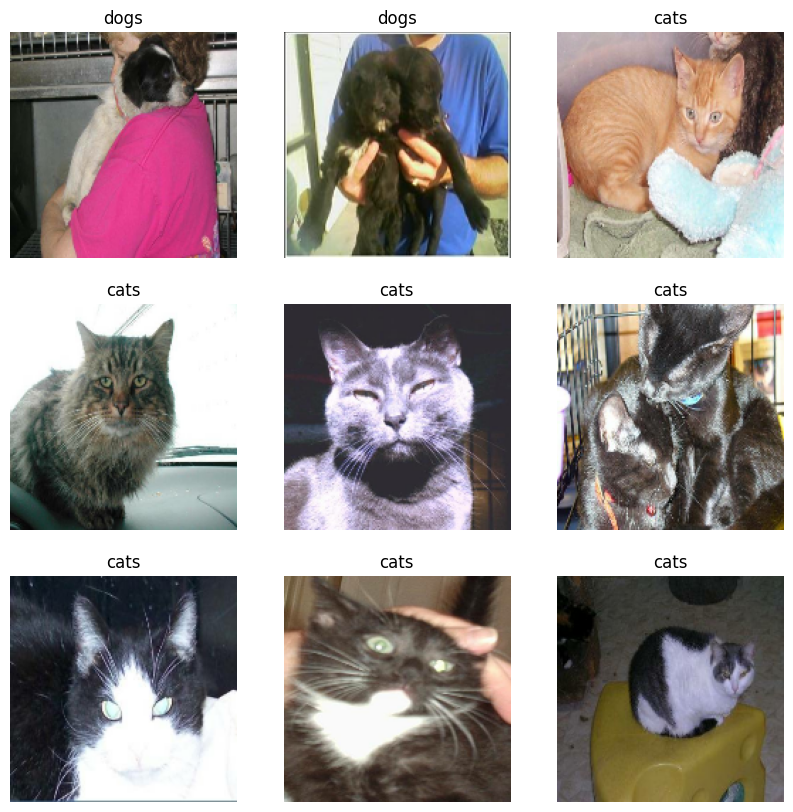

In [39]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Separating Test data from Validation

In [40]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [41]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_dataset)}')

Number of validation batches: 26
Number of test batches: 6


Prefetch data to improve performance

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [43]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

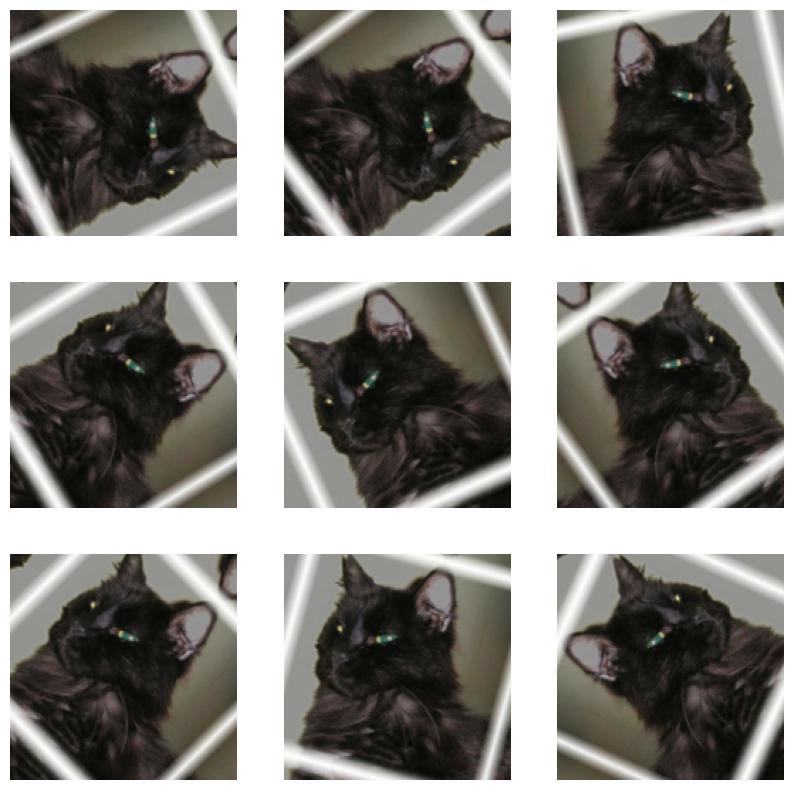

In [44]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Preprocessing data according to the model

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Loading the mobile_net_v2 model with only the lower convolution layers

In [46]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Testing what the output of the feature extractor / lower convolution layers is. They are 5x5x1280 with 32 as the batch size as set in the beginning

In [47]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freeze the convolution layers

In [48]:
base_model.trainable = False

Architecture of the Model

In [49]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

Does a Max Pool over the 5x5 part. Thus only keeping a 1280 size vector per image from the channels

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Adding one Dense layer to classify

In [51]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [52]:
print(prediction_batch)

tf.Tensor(
[[0.61074066]
 [0.64068025]
 [0.7477496 ]
 [0.7206473 ]
 [0.58867115]
 [0.4098634 ]
 [0.53432256]
 [0.33279964]
 [0.57241625]
 [0.5789051 ]
 [0.38119772]
 [0.30403763]
 [0.55892617]
 [0.46343124]
 [0.7635204 ]
 [0.6201164 ]
 [0.70485073]
 [0.33695987]
 [0.50532657]
 [0.35605255]
 [0.52233136]
 [0.74470556]
 [0.62580615]
 [0.68228465]
 [0.785531  ]
 [0.4134817 ]
 [0.6968066 ]
 [0.7358183 ]
 [0.39577216]
 [0.60960096]
 [0.7968111 ]
 [0.18812762]], shape=(32, 1), dtype=float32)


The final model using data augmentation, preprocessing, the convolution layers, the averaging layer and the final dense layer

In [53]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

The 2 is there because of model.trainable_variables being a 2d matrix with dimenstion (2, something) where the 2 signifies the weights and biases

In [55]:
len(model.trainable_variables)

2

So, as normally expected, 1280 weights and 1 bias term since there is only one dense layer

In [56]:
len(list(model.trainable_variables[0])), len(list(model.trainable_variables[1]))

(1280, 1)

Reduced the learning rate since we are Fine Tuning a model. And since the output is from [-1,1] for binary classification, we are using BinaryCrossentropy and BinaryAccuracy

In [57]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [58]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 40s 539ms/step - loss: 0.6454 - accuracy: 0.6400 - val_loss: 0.4935 - val_accuracy: 0.7884
Epoch 2/10
63/63 [==============================] - 32s 508ms/step - loss: 0.4937 - accuracy: 0.7750 - val_loss: 0.3619 - val_accuracy: 0.8923
Epoch 3/10
63/63 [==============================] - 31s 486ms/step - loss: 0.4138 - accuracy: 0.8310 - val_loss: 0.2853 - val_accuracy: 0.9282
Epoch 4/10
63/63 [==============================] - 30s 478ms/step - loss: 0.3336 - accuracy: 0.8760 - val_loss: 0.2340 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 30s 473ms/step - loss: 0.2923 - accuracy: 0.8950 - val_loss: 0.2008 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 30s 469ms/step - loss: 0.2667 - accuracy: 0.8955 - val_loss: 0.1776 - val_accuracy: 0.9666
Epoch 7/10
63/63 [==============================] - 30s 476ms/step - loss: 0.2524 - accuracy: 0.9040 - val_loss: 0.1530 - val_accuracy: 0.9715
Epoch 8/10

Plotting the learning curves

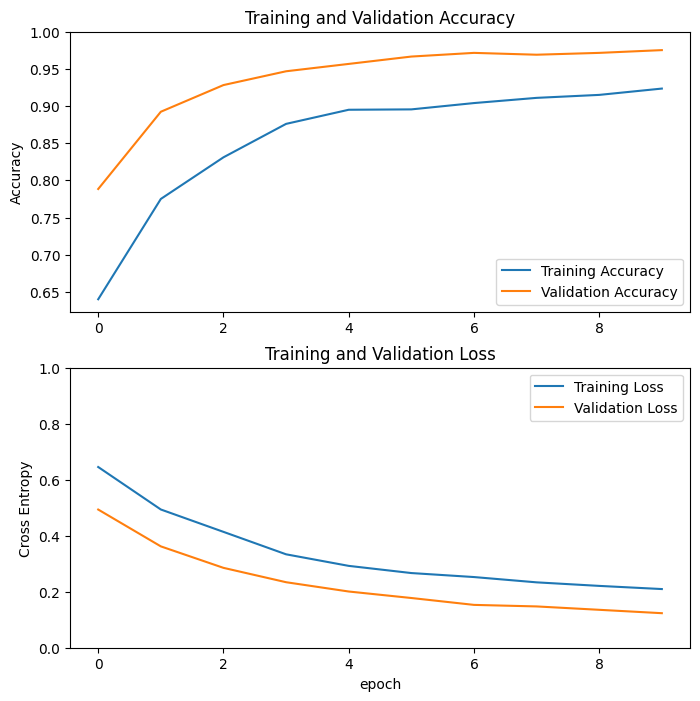

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This was simply Transfer Learning where we didn't mess with the pretrained model at all. We can alternatively also allow some of the upper convolution layers to be trained as well. This should be done after first training the top dense layers while keeping the pretrained model frozen though since otherwise it will mess it up.